# Regressão Linear com NumPy

## Objetivos deste experimento

Este exemplo utiliza regressão linear para estimar o comprimento das sépalas da íris a partir do seu comprimento das pétalas.
Utiliza-se programação totalmente NumPy com:
- o **cálculo do gradiente**,
- a **função de perda** e
- a atualização dos parâmetros são feitos de forma explícita.
- A rede é criada com uma camada como uma classe

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinear_Otimizacao.png)

## Importação dos pacotes

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt   # para plotting

from sklearn.datasets import load_iris  # para carregar dataset

import numpy as np  # processamento matricial

np.random.seed(1234)

## Dataset

### Leitura dos dados

In [2]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_train = data[:,0:1]
y_train = data[:,1:2]

n_samples = x_train.shape[0]
print('x_train.shape:',x_train.shape, x_train.dtype)
print('y_train.shape:',y_train.shape, y_train.dtype)

print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train.shape: (50, 1) float64
y_train.shape: (50, 1) float64
x_train[:5]:
 [[7. ]
 [6.4]
 [6.9]
 [5.5]
 [6.5]]
y_train[:5]:
 [[4.7]
 [4.5]
 [4.9]
 [4. ]
 [4.6]]


### Normalização dos dados

In [3]:
x_train -= x_train.min()
x_train /= x_train.max()
y_train -= y_train.min()
y_train /= y_train.max()

Text(0, 0.5, 'Comprimento petalas')

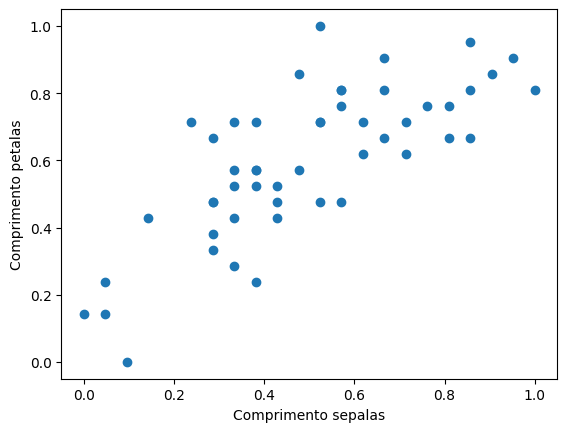

In [4]:
plt.scatter(x_train,y_train)
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')

## Modelo da rede

### Reta de ajuste

A equação da reta no plano necessita de dois parâmetros, aqui denominados $w_0$ (*bias*) e inclinação $w_1$. Veja figura:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/linhareta.png)

A reta de ajuste será dada por:

$$ \hat{y} = w_0 + w_1 x $$

onde
* $w_1$ é o coeficiente angular da reta e
* $w_0$ é a interseção do eixo vertical quando x é igual a zero, também denominado de *bias*.
* $x$ é a variável de entrada (comprimento das sépalas) e
* $\hat{y}$ é a predição (comprimento estimado das pétalas).

### Linear Regression Model

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinearNeuronio.png)

### Formulação matricial do neurônio

* $\mathbf{w} = [w_0 \ w_1]$ é vetor linha de parâmetros e
* $\mathbf{x} = [1 \ x_0] $ é vetor linha de uma amostra (com *bias*).

$$ \hat{y} = 1 w_0 + x_0 w_1 $$

$$ [\hat{y}] = [1 \ x_0] \begin{bmatrix} w_0 \\ w_1 \end{bmatrix} $$

$$ \mathbf{\hat{y}} = \mathbf{x} \mathbf{w^T} $$

### Fazendo o predict de várias amostras

$$ \begin{matrix}
\begin{bmatrix}
\hat{y}_0\\
\hat{y}_1\\
\\
\hat{y}_{M-1}
\end{bmatrix} &=& \begin{bmatrix}
1 & x_0 \\
1 & x_1\\
\\
1 & x_{M-1} \\
\end{bmatrix}
&
\begin{bmatrix}
w_0\\
w_1
\end{bmatrix} \\
(M,1) & & (M,2) & (2,1) \\
\end{matrix} $$

### Preenchendo x com coluna de 1's para bias

In [11]:
x_train_bias = np.hstack([np.ones(shape=(n_samples,1)), x_train])

In [12]:
x_train_bias

array([[1.        , 1.        ],
       [1.        , 0.71428571],
       [1.        , 0.95238095],
       [1.        , 0.28571429],
       [1.        , 0.76190476],
       [1.        , 0.38095238],
       [1.        , 0.66666667],
       [1.        , 0.        ],
       [1.        , 0.80952381],
       [1.        , 0.14285714],
       [1.        , 0.04761905],
       [1.        , 0.47619048],
       [1.        , 0.52380952],
       [1.        , 0.57142857],
       [1.        , 0.33333333],
       [1.        , 0.85714286],
       [1.        , 0.33333333],
       [1.        , 0.42857143],
       [1.        , 0.61904762],
       [1.        , 0.33333333],
       [1.        , 0.47619048],
       [1.        , 0.57142857],
       [1.        , 0.66666667],
       [1.        , 0.57142857],
       [1.        , 0.71428571],
       [1.        , 0.80952381],
       [1.        , 0.9047619 ],
       [1.        , 0.85714286],
       [1.        , 0.52380952],
       [1.        , 0.38095238],
       [1.

### Classe com o modelo da rede

In [14]:
class Net():
    def __init__(self, n_in, n_out):
        self.w = np.random.uniform(-0.1,0.1,(n_out,n_in)) #inicialização dos parâmetros

    def forward(self, x_bias):
        return x_bias.dot(self.w.T)

### Criando a rede, instanciando o objeto model

In [15]:
model = Net(2,1) # duas entradas (1 + x0) e uma saída y_pred

### Testando o predict da rede (mesmo sem treiná-la)

In [16]:
xin = np.random.randn(4,2) # 4 amostras, 2 entradas (1 + x0)
ypred = model.forward(xin)
ypred

array([[-0.05100507],
       [-0.01216805],
       [ 0.02717522],
       [-0.01732928]])

## Treinamento via gradiente descendente

Função de perda:
$$ J(\hat{y_i},y_i) = \frac{1}{M} \sum_{i=0}^{M-1} (\hat{y_i} - y_i)^2 $$

Gradiente:
$$  \mathbf{\nabla{J_w}} = \frac{2}{M}\mathbf{x^T}(\mathbf{x w^T} - \mathbf{y}) $$

Atualização dos parâmetros pelo gradiente descendente:
$$ \mathbf{w} = \mathbf{w} − \eta (\mathbf{\nabla J_w})^T $$

### Laço de treinamento

In [17]:
num_epochs = 100
learning_rate = 0.5
for epoch in range(num_epochs):

    # forward - predict
    y_pred = model.forward(x_train_bias)

    #loss cálculo da função de perda
    loss = np.square(y_pred - y_train).mean()

    # cálculo do gradiente pelas derivadas parciais
    w_grad = (2.0/n_samples) * (x_train_bias.T).dot(x_train_bias.dot(model.w.T) - y_train)

    # gradiente descendente
    model.w = model.w - learning_rate * w_grad.T

    # verbose
    if (epoch+1) % 1 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss))

Epoch[1/100], loss: 0.339831
Epoch[2/100], loss: 0.050684
Epoch[3/100], loss: 0.031016
Epoch[4/100], loss: 0.029003
Epoch[5/100], loss: 0.028210
Epoch[6/100], loss: 0.027556
Epoch[7/100], loss: 0.026968
Epoch[8/100], loss: 0.026434
Epoch[9/100], loss: 0.025949
Epoch[10/100], loss: 0.025509
Epoch[11/100], loss: 0.025109
Epoch[12/100], loss: 0.024746
Epoch[13/100], loss: 0.024417
Epoch[14/100], loss: 0.024118
Epoch[15/100], loss: 0.023846
Epoch[16/100], loss: 0.023600
Epoch[17/100], loss: 0.023376
Epoch[18/100], loss: 0.023173
Epoch[19/100], loss: 0.022988
Epoch[20/100], loss: 0.022821
Epoch[21/100], loss: 0.022669
Epoch[22/100], loss: 0.022531
Epoch[23/100], loss: 0.022405
Epoch[24/100], loss: 0.022291
Epoch[25/100], loss: 0.022188
Epoch[26/100], loss: 0.022094
Epoch[27/100], loss: 0.022009
Epoch[28/100], loss: 0.021932
Epoch[29/100], loss: 0.021862
Epoch[30/100], loss: 0.021798
Epoch[31/100], loss: 0.021740
Epoch[32/100], loss: 0.021687
Epoch[33/100], loss: 0.021640
Epoch[34/100], loss

## Avaliação

### Predict

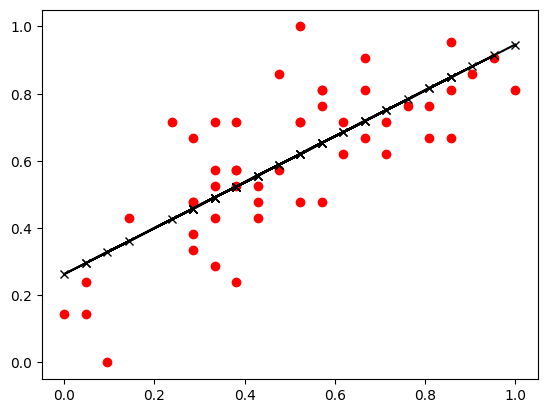

In [18]:
y_pred = model.forward(x_train_bias)
plt.plot(x_train, y_train, 'ro', label='Original data')
plt.plot(x_train, y_pred, 'kx-', label='Fitting Line')

### Parâmetros treinados

In [19]:
print(model.w)

[[0.26306045 0.68314988]]


### Avaliação do modelo

In [20]:
loss = np.square(y_pred - y_train).mean()
loss

np.float64(0.02117008324736041)

### Valor ótimo, solução analítica

$$  \mathbf{w} =(\mathbf{x^T} \mathbf{x})^{−1}\mathbf{x^T} \mathbf{y} $$

In [21]:
x = x_train_bias
y = y_train
w_opt = (np.linalg.inv((x.T).dot(x)).dot(x.T)).dot(y)
print(w_opt.T)

[[0.26134159 0.68646976]]


# Exercícios

## Questões

1. Quantos parâmetros são treinados nesse modelo


- Em uma regressão linear simples com apenas um atributo de entrada, o modelo aprende:


1 peso (coeficiente angular)

1 bias (intercepto)

Em resumo, 02 parâmetros.


2. Qual é o número de atributos de entrada para a rede?
 - um único atributo, que é exibido como x_train

3. Qual é o número de saídas da rede?
- Como é um problema de regressão univariada, o modelo prevê apenas um valor numérico para cada amostra.


4. Suponha que eu tenha agora 5 mil amostras para fazer a predição. Qual é o shape da matriz de entrada?
   Qual é o shape do matriz de saída?
    - Como temos 1 atributo de entrada, mas o modelo real usa uma coluna extra de 1s para o bias, então:

X tem 2 colunas → [1, x].

- Matriz de entrada (X):
(
5000
×
2
)
(5000×2)
 - Matriz de saída (y_pred):
(
5000
×
1
)
(5000×1)

Ou em formato Python:

X.shape = (5000, 2)

y_pred.shape = (5000, 1)


## Atividades

1. Modifique o laço do treinamento via gradiente descendente para guardar em uma lista, o valor da perda no final
   de cada época. Após o treinamento, plote o valor da perda em função da época.
2. Calcule o valor da perda (MSE) da rede com os parâmetros inicializados, sem serem treinados.
3. Coloque os valores dos pesos da solução ótima analítica no modelo da rede e calcule o valor da perda (MSE) e
   compare com o valor da perda obtida pelo método da otimização via gradiente descendente.

# Aprendizados

### Laço de Treinamento Modificado (com registro de Loss e Plotagem)

Esta seção implementa o laço de treinamento, registrando o valor da função de perda em cada época e, ao final, gerando um gráfico da perda ao longo do tempo.

Iniciando treinamento com o modelo atual...
Epoch[10/100], loss: 0.021169
Epoch[20/100], loss: 0.021169
Epoch[30/100], loss: 0.021169
Epoch[40/100], loss: 0.021169
Epoch[50/100], loss: 0.021169
Epoch[60/100], loss: 0.021169
Epoch[70/100], loss: 0.021169
Epoch[80/100], loss: 0.021169
Epoch[90/100], loss: 0.021169
Epoch[100/100], loss: 0.021169

Treinamento concluído. Última loss: 0.021169


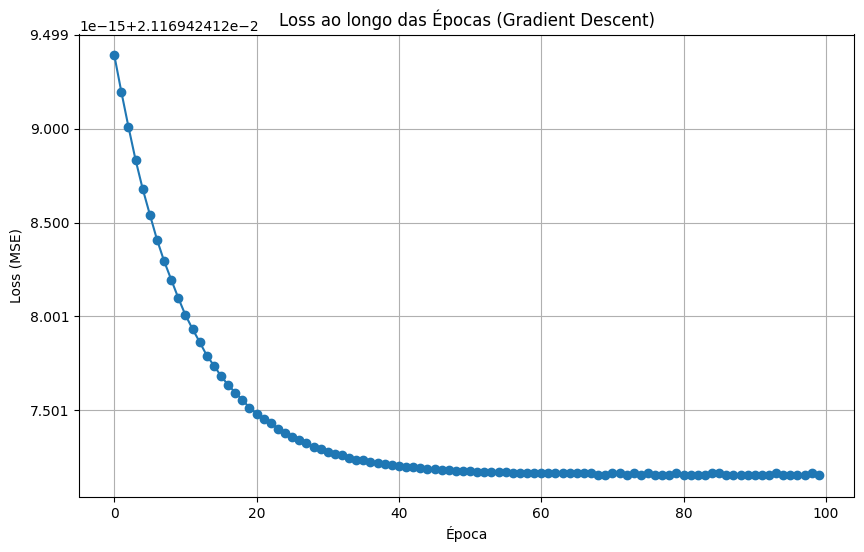

In [29]:
num_epochs = 100
learning_rate = 0.5
loss_history = []

print('Iniciando treinamento com o modelo atual...')

for epoch in range(num_epochs):

    # forward - predict
    y_pred = model.forward(x_train_bias)

    #loss cálculo da função de perda (MSE)
    loss = np.square(y_pred - y_train).mean()
    loss_history.append(loss) # Armazena a perda da época

    # cálculo do gradiente pelas derivadas parciais
    # w_grad = (2.0/n_samples) * (x_train_bias.T).dot(x_train_bias.dot(model.w.T) - y_train)
    # A linha acima tem um pequeno erro na formula do gradiente para MSE com bias.
    # A formula correta considerando x_bias e w como [w0, w1] e y_pred = x_bias @ w.T
    # gradiente em relação a w0 e w1 é: (2/M) * (x_train_bias.T) @ (y_pred - y_train)
    w_grad = (2.0/n_samples) * (x_train_bias.T).dot(y_pred - y_train)

    # gradiente descendente
    model.w = model.w - learning_rate * w_grad.T

    # verbose
    if (epoch+1) % 10 == 0: # Imprime a cada 10 épocas para evitar muita saída
        print('Epoch[{}/{}], loss: {:.6f}'.format(epoch+1, num_epochs, loss))

print('\nTreinamento concluído. Última loss: {:.6f}'.format(loss_history[-1]))

# Plotando o valor da perda em função da época
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), loss_history, marker='o', linestyle='-')
plt.title('Loss ao longo das Épocas (Gradient Descent)')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

### Calculando a Perda (MSE) de uma Rede com Parâmetros Inicializados (Não Treinados)

Para avaliar a perda de uma rede com parâmetros **não treinados**, é necessário instanciar um novo objeto `Net`, garantindo que seus pesos sejam aleatórios e ainda não otimizados.

In [31]:
# Criar uma nova instância do modelo para simular o estado inicial (pesos aleatórios)
untrained_model = Net(2,1)

# Fazer uma predição com este modelo recém-inicializado
y_pred_untrained = untrained_model.forward(x_train_bias)

# Calcular a perda (MSE) para este modelo não treinado
untrained_loss = np.square(y_pred_untrained - y_train).mean()

print(f'Pesos da nova rede (não treinados): {untrained_model.w.flatten()}')
print(f'Loss (MSE) da rede com parâmetros inicializados e não treinados: {untrained_loss:.6f}')

Pesos da nova rede (não treinados): [ 0.07382548 -0.01276532]
Loss (MSE) da rede com parâmetros inicializados e não treinados: 0.333644


### Perda com os Parâmetros Ótimos Analíticos

Agora, vamos carregar os pesos `w_opt` (obtidos pela solução analítica) em uma nova instância do modelo e calcular a perda correspondente. Isso nos permitirá comparar a performance do gradiente descendente com a solução exata para este problema de regressão linear.

In [33]:

# Criar uma nova instância do modelo para carregar os pesos ótimos analíticos
optimal_model_analytic = Net(2,1)

# Atribuir os pesos ótimos analíticos ao modelo.
# Lembre-se que w_opt é um vetor coluna e model.w espera um vetor linha, por isso a transposição (.T).
optimal_model_analytic.w = w_opt.T

# Fazer uma predição com este modelo com pesos ótimos
y_pred_optimal_analytic = optimal_model_analytic.forward(x_train_bias)

# Calcular a perda (MSE) com os pesos ótimos analíticos
optimal_analytic_loss = np.square(y_pred_optimal_analytic - y_train).mean()

print(f'Pesos ótimos analíticos (w_opt): {w_opt.flatten()}')
print(f'Loss (MSE) com parâmetros ótimos analíticos: {optimal_analytic_loss:.6f}')
print(f'Loss (MSE) obtida pelo Gradiente Descendente (final): {loss_history[-1]:.6f}')

# Comparação dos resultados
if np.isclose(optimal_analytic_loss, loss_history[-1], atol=1e-5):
    print('\nAs perdas são muito próximas, indicando que o Gradiente Descendente convergiu para a solução ótima.')
elif optimal_analytic_loss < loss_history[-1]:
    print('\nA perda com os parâmetros ótimos analíticos é menor, o que é esperado. O Gradiente Descendente se aproximou da solução ótima.')
else:
    print('\nA perda com os parâmetros ótimos analíticos é maior que a do Gradiente Descendente, o que é inesperado. Pode indicar um problema no cálculo ou treinamento do GD.')

Pesos ótimos analíticos (w_opt): [0.26134159 0.68646976]
Loss (MSE) com parâmetros ótimos analíticos: 0.021169
Loss (MSE) obtida pelo Gradiente Descendente (final): 0.021169

As perdas são muito próximas, indicando que o Gradiente Descendente convergiu para a solução ótima.
